In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
from format_rules import format_rules
#from server_association import server_association
from Server_Assign import server_association
#from apyori import apriori 

In [2]:
#load data
#df=pd.read_csv('/home/natalie/Documents/Manifold/df_test.csv')
client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()), low_memory=False)


df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")


In [29]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])
#create a normalized latency column = duration/packets
df['norm_latency']=df['Duration']/df['Packets']

In [30]:
def convert_si_to_number(x):
    total_stars = 0
    if 'k' in x:
        if len(x) > 1:
            total_stars = float(x.replace('k', '')) * 1000 # convert k to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000 # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000 # convert B to a Billion
    else:
        total_stars = int(x) # Less than 1000
    return int(total_stars)

In [31]:
df.Bytes=df.Bytes.astype('str')
test_list=df.Bytes

[i for i, s in enumerate(test_list) if 'M' in s]#show where the M errors are happening

test_list= [convert_si_to_number(x) for x in test_list]
df.Bytes=test_list #bring it back into the dataframe


In [32]:
#add hour column, where it is a value 1-24, and repeats each day
df['hour']=None
df['hour']=pd.DatetimeIndex(df['Date']).hour

#lambda x: x[0]).head()

In [33]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,hour,pairs,pairs2,norm_latency
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,0,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0015
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,0,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0000
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,0,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0020
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,0,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)",0.0000
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,0,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0000


## Implement Frequent Pattern (FP) - Growth algorithm

https://fp-growth.readthedocs.io/en/latest/usage.html

This algorithm
1. Counts occurence of items in dataset in 1st pass
2. Build FP-tree by inserting instances, and adds count to each instance based on the number of times it appears in the dataset. Those infrequent instances are dropped from the tree.

This allows the frequentest set to be generated organically, instead of creating a list of each itemset and checking if it does/does not pass minimum threshold (like Apriori algorithm)

#### Vocabulary
 - itemset = all items in 1 transaction
A "pattern" is a conjunction of items, or the unique itemset.
A "rule" X --> Y means if you buy X you are likely to buy Y, or in this case if X IP address is used Y IP address is likely also


#### Evaluation metrics include:

1. Support = how frequently it occurs. The number of transactions of that unique itemset / all transactions. In this case: number of times IP pair occurs/all requests

2. Confidence = how often rule is likely to be true. frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. P(Ey|Ex)

3. Lift = How likely is item Y given item X occurs, controlling for how frequent Y occurs in the entire dataset. For rule X-->Y, lift = P(Y|X)/P(Y).
    Lift = 1 means X and Y are independent
    Lift >1 = X and Y are positively correlated
    Lift <1 = X and Y are negatively correlated

## 2. Implement Frequentest paterns algorithm

Before we run this algorithm, we should have some idea of the minimum threshold we want to set. This is the "support" for each IP pair. Support = % of time this pair occurs in dataset.

### Do this for each hour in the dataset, we think that frequency in pairs might change with time.

In [20]:
df1=df[df['hour']==1]

#rules_df.loc[rules_df['pair_ID']==0, 'server_B'] = 0

In [34]:
data_groups=[]

for i in range(0,25):
    data=df[df['hour']==i]
    data_groups.append(data)

In [55]:
#make individual 'pairs count' frequency tables so we can get a good value for our minimum support and keep it consitent.
#We are selecting the 80th percentile as our min threshold, so each group will ahve a different 80th value.
i=data_groups[1]

pairs_count=(df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by 
np.percentile(pairs_count['frequency'], [80])[0]

126.0

In [81]:
pairs_list=[]
per80_list=[]
data_l_list=[]
patterns_list=[]
rules_list=[]
confidence=0.7 #this means the rule is likely to be true 20% of the time, it is a high threshold, used for testing


for i in data_groups:    
    data_l=list(i['pairs'])
    pairs_count=(i.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
    pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
    pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair
    pairs_list.append(pairs_count)
    per_80=(pairs_count['frequency'].quantile(.8))
    patterns = pyfpgrowth.find_frequent_patterns(data_l, per_80) 
    patterns_list.append(patterns)
    rules = pyfpgrowth.generate_association_rules(patterns, confidence)
    rules_list.append(rules)
      

In [83]:
#format the rules, bring back in the other info on latency rank
rules_list=rules_list[:-1]#last item was empty, remove it
formated_rules=[]
apps_server=20

for i in rules_list:
    formatrule=format_rules(i, df, apps_server)
    formated_rules.append(formatrule)


## Assign Servers to each IP address in the rules dataframe

Start with the highest rank IP pair, assign matching servers and then move on to the next highest rank pair until that server is full. This is a 'dumb' approach, but  it clearly assigns things based on priority and gets a proof of concept. Because IP addresses repeat throughout the rules dataset, we will remove repeated IPs leaving the highest ranked IP.

For this exercise we assume a server can hold 20 apps, or 10 pairs

In [97]:
range(len(formated_rules))

range(0, 24)

In [99]:
#assign IPs to the servers at each hour
server_assign_list=[]
total_latency_list=[]
total_latency_model_list=[]
avg_latency_list=[]
avg_latency_model_list=[]


for i, j in zip(formated_rules, data_groups) :
    server_assignments, total_latency, total_latency_model, avg_latency, avg_latency_model = server_association(i, j, apps_server) #this function loaded fr
    server_assign_list.append(server_assignments)
    total_latency_list.append(total_latency)
    total_latency_model_list.append(total_latency_model)
    avg_latency_list.append(avg_latency)
    avg_latency_model_list.append(avg_latency_model)
    

In [92]:
#original times

df_hour=df.groupby('hour')['Duration'].sum()

In [93]:
df_hour

hour
0       2520.962
1       2556.084
2       2584.281
3       2634.629
4       3074.361
5       2269.169
6       8304.769
7      27839.168
8      39943.202
9     126588.410
10    128716.377
11    135805.016
12    148788.455
13    164290.552
14    210026.051
15    235877.035
16    269364.962
17    181901.313
18    181585.553
19    105866.349
20     26332.451
21      2324.935
22      2420.664
23      2504.833
Name: Duration, dtype: float64

In [103]:
#bring together all the durations for the actual data and the model
hours=range(0,24)
model_output=pd.DataFrame({'hours':hours,'total_latency_list': total_latency_list, 'total_latency_model_list': total_latency_model_list, 'avg_latency_list': avg_latency_list, 'avg_latency_model_list': avg_latency_model_list})
model_output.columns=['hours', 'total_latency', 'total_latency_model', 'avg_latency', 'avg_latency_model']
model_output.head()

,hours,total_latency,total_latency_model,avg_latency,avg_latency_model
0,0,2520.962,1131.550,0.060149,0.026998
1,1,2556.084,1292.347,0.069988,0.035385
2,2,2584.281,1100.764,0.069887,0.029768
3,3,2634.629,1331.878,0.071291,0.036040
4,4,3074.361,1448.215,0.083327,0.039252


In [ ]:
time=['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4ppm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']

How did this model do?

In [104]:
model_output['total_latency'].sum() #original total latency

2014119.5810000002

In [105]:
model_output['total_latency_model'].sum()#predicted latency, does not match the other output.... what is wrong...

1679517.0219999999

## Overall, this is a % improvement:

In [112]:
(model_output['total_latency'].sum()-model_output['total_latency_model'].sum())/model_output['total_latency'].sum()

0.16612844746480834

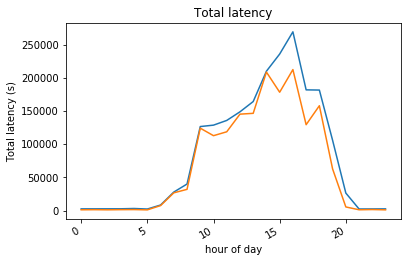

In [108]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
ax.plot(model_output['hours'], model_output['total_latency'])
ax.plot(model_output['hours'], model_output['total_latency_model'])


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Total latency (s)')
plt.xlabel('hour of day')
plt.title('Total latency')
plt.show()

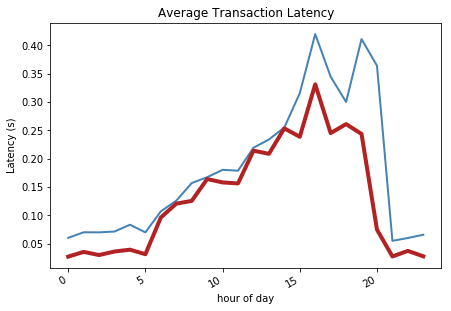

<Figure size 432x288 with 0 Axes>

In [119]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(model_output['hours'], model_output['avg_latency'], color='steelblue', linewidth=2.0)
ax.plot(model_output['hours'], model_output['avg_latency_model'], color='firebrick', linewidth=4.0)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency')
plt.show()
plt.savefig('Average_transaction_latency_hours_day.png')